In [1]:
import numpy as np
x_train = np.load("../data/preserve100/x_train.npy")
y_train = np.load("../data/preserve100/y_train.npy")
x_test = np.load("../data/preserve100/x_test.npy")
y_test = np.load("../data/preserve100/y_test.npy")

In [2]:
!pip -V


pip 24.0 from /work1/anaconda3/envs/upgrad_3812/lib/python3.8/site-packages/pip (python 3.8)


In [3]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (2120907, 31)
y_train (2120907, 1)
x_test (706969, 31)
y_test (706969, 1)


In [4]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=3)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
x_test_smote, y_test_smote = smote.fit_resample(x_test, y_test)

In [5]:
x_train=x_train_smote
y_train=y_train_smote
x_test=x_test_smote
y_test=y_test_smote

In [6]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (25546365, 31)
y_train (25546365,)
x_test (8523435, 31)
y_test (8523435,)


In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')

# Load preprocessed data
# x_train = np.load("../data/preserve10/x_train.npy")
# y_train = np.load("../data/preserve10/y_train.npy")

# Define VAE parameters
original_dim = x_train.shape[1]
intermediate_dim = 64
latent_dim = 32
num_classes = len(np.unique(y_train))

# VAE Encoder
inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Define the VAE model
vae = Model(inputs, x_decoded_mean)

# Custom VAE Loss Layer
class VAELossLayer(Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        reconstruction_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_decoded_mean), axis=-1)
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        self.add_loss(tf.reduce_mean(reconstruction_loss + kl_loss))
        return x_decoded_mean

# Apply the VAE loss layer
vae_output = VAELossLayer()([inputs, x_decoded_mean, z_mean, z_log_var])
vae = Model(inputs, vae_output)
vae.compile(optimizer='adam')
vae.summary()

# Train VAE
vae.fit(x_train, x_train, epochs=10, batch_size=128,validation_split=0.1)

# Classifier using the VAE latent space
class VAEClassifier(Model):
    def __init__(self, vae, latent_dim, num_classes):
        super(VAEClassifier, self).__init__()
        self.vae_encoder = Model(vae.input, vae.get_layer(index=-3).output)
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        z = self.vae_encoder(inputs)
        return self.classifier(z)

# Build the classifier
classifier = VAEClassifier(vae, latent_dim, num_classes)
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train classifier on VAE latent space
classifier.fit(x_train, y_train, epochs=10, batch_size=128,validation_split=0.1)


2024-11-15 18:03:24.054013: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-15 18:03:24.063005: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-15 18:03:24.093367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731674004.144346 2125123 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731674004.159659 2125123 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 18:03:24.204436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      2,048 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 32)        │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      2,112 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 31)        │      2,015 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 31)        │          0 │ input_layer[0][0… │
│ (VAELossLayer)      │                   │            │ dense_4[0][0],    │
│                     │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,335 (40.37 KB)

 Trainable params: 10,335 (40.37 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
179623/179623 ━━━━━━━━━━━━━━━━━━━━ 362s 2ms/step - loss: nan - val_loss: nan
Epoch 2/10
179623/179623 ━━━━━━━━━━━━━━━━━━━━ 354s 2ms/step - loss: nan - val_loss: nan
Epoch 3/10
179623/179623 ━━━━━━━━━━━━━━━━━━━━ 353s 2ms/step - loss: nan - val_loss: nan
Epoch 4/10
179623/179623 ━━━━━━━━━━━━━━━━━━━━ 356s 2ms/step - loss: nan - val_loss: nan
Epoch 5/10
179623/179623 ━━━━━━━━━━━━━━━━━━━━ 359s 2ms/step - loss: nan - val_loss: nan
Epoch 6/10
179623/179623 ━━━━━━━━━━━━━━━━━━━━ 356s 2ms/step - loss: nan - val_loss: nan
Epoch 7/10
179623/179623 ━━━━━━━━━━━━━━━━━━━━ 356s 2ms/step - loss: nan - val_loss: nan
Epoch 8/10
179623/179623 ━━━━━━━━━━━━━━━━━━━━ 355s 2ms/step - loss: nan - val_loss: nan
Epoch 9/10
179623/179623 ━━━━━━━━━━━━━━━━━━━━ 354s 2ms/step - loss: nan - val_loss: nan
Epoch 10/10
179623/179623 ━━━━━━━━━━━━━━━━━━━━ 353s 2ms/step - loss: nan - val_loss: nan
Epoch 1/10
179623/179623 ━━━━━━━━━━━━━━━━━━━━ 344s 2ms/step - accuracy: 0.0741 - loss: nan - val_accuracy: 0.0000e+00 -

In [8]:
print("Train Accuracy")
classifier.evaluate(x_train, 
               y_train, 
               verbose=2)

Train Accuracy
798324/798324 - 782s - 980us/step - accuracy: 0.0667 - loss: nan


[nan, 0.06666667014360428]

In [9]:
print("Test Accuracy")
classifier.evaluate(x_test, 
               y_test, 
               verbose=2)

Test Accuracy
266358/266358 - 259s - 971us/step - accuracy: 0.0667 - loss: nan


[nan, 0.06666667014360428]

In [11]:
import pandas as pd
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Get predictions
y_test_pred = classifier.predict(x_test)

# If the model outputs probabilities, convert them to class labels
y_test_pred_labels = y_test_pred.argmax(axis=1)  # Assuming output is one-hot encoded or probabilities

# Flatten y_test if it is a pandas DataFrame or multi-dimensional
if isinstance(y_test, pd.DataFrame):  # Check if y_test is a pandas DataFrame
    y_test = y_test.to_numpy().ravel()
elif len(y_test.shape) > 1:
    y_test = y_test.flatten()

# Calculate and print precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_test, y_test_pred_labels, digits=4))

# Optionally, calculate overall metrics in percentage
precision = precision_score(y_test, y_test_pred_labels, average='weighted') * 100
recall = recall_score(y_test, y_test_pred_labels, average='weighted') * 100
f1 = f1_score(y_test, y_test_pred_labels, average='weighted') * 100

print(f"Weighted Precision: {precision:.2f}%")
print(f"Weighted Recall: {recall:.2f}%")
print(f"Weighted F1-Score: {f1:.2f}%")


266358/266358 ━━━━━━━━━━━━━━━━━━━━ 274s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.0667    1.0000    0.1250    568229
           1     0.0000    0.0000    0.0000    568229
           2     0.0000    0.0000    0.0000    568229
           3     0.0000    0.0000    0.0000    568229
           4     0.0000    0.0000    0.0000    568229
           5     0.0000    0.0000    0.0000    568229
           6     0.0000    0.0000    0.0000    568229
           7     0.0000    0.0000    0.0000    568229
           8     0.0000    0.0000    0.0000    568229
           9     0.0000    0.0000    0.0000    568229
          10     0.0000    0.0000    0.0000    568229
          11     0.0000    0.0000    0.0000    568229
          12     0.0000    0.0000    0.0000    568229
          13     0.0000    0.0000    0.0000    568229
          14     0.0000    0.0000    0.0000    568229

    accuracy                         0.0667   8523435
   macro

66590/66590 ━━━━━━━━━━━━━━━━━━━━ 85s 1ms/step - accuracy: 0.2325 - loss: nan
Test Accuracy: 0.0667
266358/266358 ━━━━━━━━━━━━━━━━━━━━ 275s 1ms/step


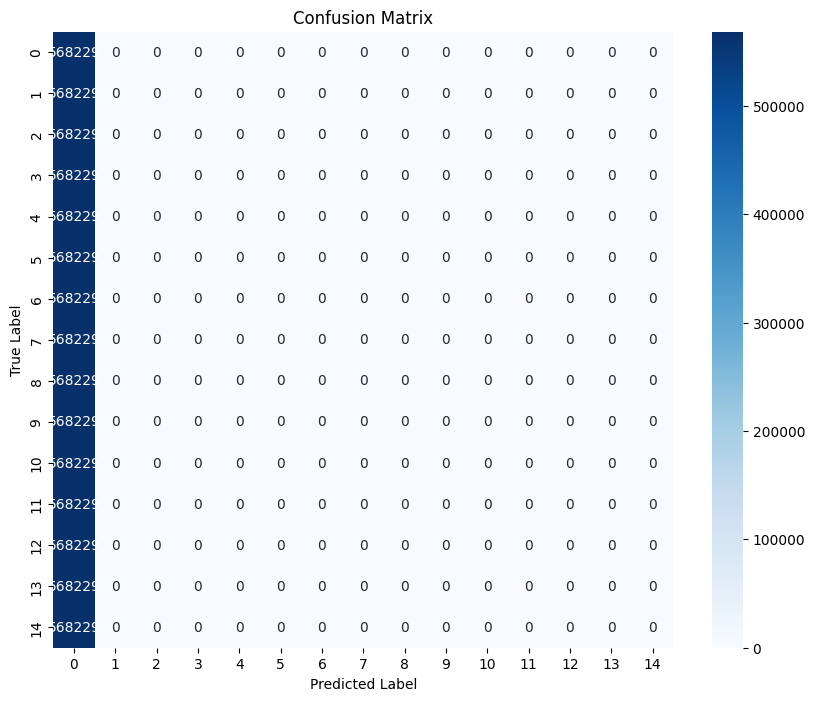

ValueError: Input contains NaN.

<Figure size 1000x800 with 0 Axes>

In [12]:
# Evaluate the model on the test data (you can also use x_train and y_train to evaluate training accuracy)
loss, accuracy = classifier.evaluate(x_test, y_test, batch_size=128)
print(f"Test Accuracy: {accuracy:.4f}")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test data
y_pred = classifier.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Dashed line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()

from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test, y_pred_classes)
print(report)


In [ ]:
from sklearn.model_selection import train_test_split

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

z_val = classifier.vae_encoder.predict(x_val)
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(z_val)

# Example: Get average cosine similarity for each sample
avg_cosine_sim = np.mean(cosine_sim_matrix, axis=1)
print("Average Cosine Similarity per sample:", avg_cosine_sim)


# 1. Plotting the Distribution of Cosine Similarities
# A histogram or KDE (Kernel Density Estimate) plot can reveal the spread of cosine similarities, indicating how closely samples are grouped in the latent space.
# Interpretation: A higher average cosine similarity suggests that samples are more clustered in the latent space. A tight clustering could indicate that the VAE encoder
# has learned meaningful features, while a wider spread might suggest that further tuning is needed.

import matplotlib.pyplot as plt
import seaborn as sns


# Plot the distribution of average cosine similarities
plt.figure(figsize=(10, 6))
sns.histplot(avg_cosine_sim, kde=True, bins=30, color="skyblue")
plt.title("Distribution of Average Cosine Similarities in Latent Space")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

# A heatmap of cosine similarities can visualize sample relationships. For simplicity, this example uses the first 20 samples in z_val.
# Interpretation: Similar samples should have higher cosine similarity values (closer to 1). You can look for high-similarity clusters 
# in the heatmap, which would suggest that certain samples share similar features in the latent space.

# Generate a cosine similarity matrix heatmap for the first 20 samples
subset_cosine_sim_matrix = cosine_sim_matrix[:20, :20]

plt.figure(figsize=(12, 10))
sns.heatmap(subset_cosine_sim_matrix, annot=True, cmap="coolwarm", cbar=True)
plt.title("Cosine Similarity Heatmap (Sample Subset)")
plt.xlabel("Samples")
plt.ylabel("Samples")
plt.show()

In [ ]:
import pandas as pd
from predictions import make_prediction, PredMetrics, get_prediction_metrics, labels
print("Test Model Detailed Report")
x_test = pd.DataFrame(x_test)
y_test = pd.DataFrame(y_test)
predictions = make_prediction(classifier, x_test, y_test)
pred_metrics = get_prediction_metrics(predictions)


print("FP Rate (FPR):", round(pred_metrics.weighted_fpr, 4))
print("FN Rate (FNR):", round(pred_metrics.weighted_fnr, 4))
print("Detection Rate:", round(pred_metrics.weighted_detection_rate, 4))
print("False Alarm Rate (FAR):", round(pred_metrics.false_alarm_rate, 4))
print("Accuracy: ", round(pred_metrics.classification_report.loc["accuracy"].iloc[0], 4))

pred_metrics.classification_report.columns = ["Precision", "Recall", "F1-score", "Quantity"]
pred_metrics.classification_report = pred_metrics.classification_report.astype({"Quantity": int})
pred_metrics.classification_report.drop("accuracy", axis=0, inplace=True)

print("\n", pred_metrics.classification_report)


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import regularizers
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf

# Load and preprocess the data
# Assuming you already have the x_train, y_train, x_test, y_test as numpy arrays

# Encode the labels into integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Apply SMOTE for balancing the dataset
smote1 = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=1)
smote2 = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=1)

x_train_resampled, y_train_resampled = smote1.fit_resample(x_train, y_train_encoded)
x_test_resampled, y_test_resampled = smote2.fit_resample(x_test, y_test_encoded)

In [ ]:
x_train_resampled = x_train 
x_test_resampled = x_test
# VAE Encoder Model
def build_vae_encoder(latent_dim):
    input_layer = Input(shape=(x_train.shape[1],))  # Input layer
    x = Dense(256, activation='relu')(input_layer)  # Hidden layer
    x = Dense(128, activation='relu')(x)  # Hidden layer
    z_mean = Dense(latent_dim)(x)  # Mean of latent space
    z_log_var = Dense(latent_dim)(x)  # Log variance of latent space
    encoder = Model(input_layer, [z_mean, z_log_var])
    return encoder

# VAE Decoder Model
def build_vae_decoder(latent_dim):
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(128, activation='relu')(latent_inputs)  # Hidden layer
    x = Dense(256, activation='relu')(x)  # Hidden layer
    decoded = Dense(x_train.shape[1], activation='sigmoid')(x)  # Output layer
    decoder = Model(latent_inputs, decoded)
    return decoder

# CGAN Generator Model (for data generation)
def build_cgan_generator(latent_dim):
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(256, activation='relu')(latent_inputs)
    x = Dense(512, activation='relu')(x)
    generated_data = Dense(x_train.shape[1], activation='sigmoid')(x)
    generator = Model(latent_inputs, generated_data)
    return generator

# CGAN Discriminator Model (for classification)
def build_cgan_discriminator():
    input_layer = Input(shape=(x_train.shape[1],))
    x = Dense(256, activation='relu')(input_layer)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    discriminator = Model(input_layer, output)
    discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    return discriminator

# VAE-CGAN Hybrid Model
def build_vaecgan_hybrid(latent_dim):
    encoder = build_vae_encoder(latent_dim)
    decoder = build_vae_decoder(latent_dim)
    generator = build_cgan_generator(latent_dim)
    discriminator = build_cgan_discriminator()

    # Define the VAE loss
    def vae_loss(x, decoded):
        xent_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, decoded))
        return xent_loss
    
    # VAE Encoder + Decoder Model
    vae = Model(encoder.input, decoder(encoder.output[0]))  # Using the z_mean from encoder
    vae.compile(optimizer=Adam(learning_rate=0.0002), loss=vae_loss)
    
    # CGAN Generator + Discriminator Model (adversarial model)
    z = Input(shape=(latent_dim,))
    generated_data = generator(z)
    discriminator_output = discriminator(generated_data)
    cgan = Model(z, discriminator_output)
    cgan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    
    return vae, cgan

# Define latent dimension for the VAE
latent_dim = 100

# Build the VAE-CGAN hybrid model
print("Build the VAE-CGAN hybrid model")
vae, cgan = build_vaecgan_hybrid(latent_dim)

# Train the VAE model first
print("Train the VAE model first")
vae.fit(x_train_resampled, x_train_resampled, epochs=1, batch_size=64)

# Train the CGAN model (discriminator and generator)
print("Train the CGAN model (discriminator and generator)")
z_fake = np.random.normal(0, 1, (x_train_resampled.shape[0], latent_dim))
cgan.fit(z_fake, np.ones((x_train_resampled.shape[0], 1)), epochs=1, batch_size=64)

# # Evaluate the model
# print("Evaluate the model")
# vae.evaluate(x_test_resampled, x_test_resampled)
# cgan.evaluate(z_fake, np.ones((x_test_resampled.shape[0], 1)))

# Extract the encoder from the VAE model
print("Extract the encoder from the VAE model")
encoder = vae.layers[0]   # Access the encoder model directly (this will be the second layer)
print(encoder)

# # Get the mean (z_mean) from the encoder output
# print("Get the mean (z_mean) from the encoder output")
# # z_mean, _ = encoder.predict(x_train_resampled)
# z_mean, _, _ = encoder.predict(x_train_resampled)

# Now, use the encoder part of the VAE for feature extraction
encoded_data = vae.layers[0]('encoder')(x_train_resampled)

# Now, use the encoded data to train a classifier
classifier = Dense(64, activation='relu')(encoded_data)
classifier = Dense(15, activation='softmax')(classifier)  # 15 classes
classifier_model = Model(inputs=vae.input, outputs=classifier)
classifier_model.compile(optimizer=Adam(learning_rate=0.0002), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the classifier
classifier_model.fit(x_train_resampled, y_train_resampled, epochs=1, batch_size=64)

# Evaluate the classifier
classifier_model.evaluate(x_test_resampled, y_test_resampled)


In [ ]:

# Build the VAE Encoder Model
def build_vae_encoder(latent_dim):
    input_layer = Input(shape=(x_train.shape[1],))  # Input layer
    x = Dense(256, activation='relu')(input_layer)  # Hidden layer
    x = Dense(128, activation='relu')(x)  # Hidden layer
    z_mean = Dense(latent_dim)(x)  # Mean of latent space
    z_log_var = Dense(latent_dim)(x)  # Log variance of latent space
    encoder = Model(input_layer, [z_mean, z_log_var])
    return encoder

# Build the VAE Decoder Model
def build_vae_decoder(latent_dim):
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(128, activation='relu')(latent_inputs)  # Hidden layer
    x = Dense(256, activation='relu')(x)  # Hidden layer
    decoded = Dense(x_train.shape[1], activation='sigmoid')(x)  # Output layer
    decoder = Model(latent_inputs, decoded)
    return decoder

# Build the CGAN Generator Model
def build_cgan_generator(latent_dim):
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(256, activation='relu')(latent_inputs)
    x = Dense(512, activation='relu')(x)
    generated_data = Dense(x_train.shape[1], activation='sigmoid')(x)
    generator = Model(latent_inputs, generated_data)
    return generator

# Build the CGAN Discriminator Model
def build_cgan_discriminator():
    input_layer = Input(shape=(x_train.shape[1],))
    x = Dense(256, activation='relu')(input_layer)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    discriminator = Model(input_layer, output)
    discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    return discriminator

# VAE-CGAN Hybrid Model
def build_vaecgan_hybrid(latent_dim):
    encoder = build_vae_encoder(latent_dim)
    decoder = build_vae_decoder(latent_dim)
    generator = build_cgan_generator(latent_dim)
    discriminator = build_cgan_discriminator()

    # VAE loss (Reconstruction + KL Divergence)
    def vae_loss(x, decoded, z_mean, z_log_var):
        xent_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, decoded))
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        return xent_loss + kl_loss
    
    vae = Model(encoder.input, decoder(encoder.output[0]))  # VAE model
    vae.compile(optimizer=Adam(learning_rate=0.0002), loss=lambda x, y: vae_loss(x, y, encoder.output[0], encoder.output[1]))
    
    z = Input(shape=(latent_dim,))
    generated_data = generator(z)
    discriminator_output = discriminator(generated_data)
    cgan = Model(z, discriminator_output)
    cgan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])
    
    return vae, cgan, encoder, decoder, generator, discriminator

# Training function
def train_vaecgan_hybrid(epochs=1, batch_size=64):
    for epoch in range(epochs):
        # Training phase
        idx = np.random.randint(0, x_train_resampled.shape[0], batch_size)
        real_data = x_train_resampled[idx]
        
        z_mean, z_log_var = encoder.predict(real_data)
        generated_data = generator.predict(z_mean)
        
        vae_loss_value = vae.train_on_batch(real_data, real_data)
        
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
        
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)
        
        z_fake = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = cgan.train_on_batch(z_fake, real_labels)
        
        # Validation phase
        z_mean_val, z_log_var_val = encoder.predict(x_val_resampled)
        generated_data_val = generator.predict(z_mean_val)
        val_vae_loss = vae.evaluate(x_val_resampled, x_val_resampled, batch_size=batch_size)
        val_d_loss_real = discriminator.evaluate(x_val_resampled, np.ones((x_val_resampled.shape[0], 1)), batch_size=batch_size)
        val_d_loss_fake = discriminator.evaluate(generated_data_val, np.zeros((generated_data_val.shape[0], 1)), batch_size=batch_size)
        
        print(f"Epoch {epoch + 1}/{epochs} - VAE Loss: {vae_loss_value}, D Loss Real: {d_loss_real[0]}, D Loss Fake: {d_loss_fake[0]}, G Loss: {g_loss[0]}")
        print(f"Validation - VAE Loss: {val_vae_loss[0]}, D Loss Real: {val_d_loss_real[0]}, D Loss Fake: {val_d_loss_fake[0]}")

# Define latent dimension for the VAE
latent_dim = 100

# Build the VAE-CGAN hybrid model
print("Building the VAE-CGAN hybrid model...")
vae, cgan, encoder, decoder, generator, discriminator = build_vaecgan_hybrid(latent_dim)

# Start training the VAE-CGAN hybrid model
print("Training the VAE-CGAN hybrid model...")
train_vaecgan_hybrid(epochs=10, batch_size=64)


In [ ]:
# Evaluate the classifier
classifier_model.evaluate(x_test, y_test)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = classifier_model.predict(x_test)  # Uncomment this line to use your trained model for predictions

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)
